# **Knots And Crosses**

Github: https://github.com/StrikerXYZ/Knots-And-Crosses




Environment:

In [158]:
import gym
import numpy as np
import random

class KnotsNCrosses(gym.Env):

  def __init__(self):
    self.done = False;
    self.observation = np.full((9), [' '],dtype=str);
    self.transitionTable = {}
    self.transitionTable[tuple(self.observation.copy())] = self.getDataForState(self.observation)
    self.valueTable = {}
    self.valueTable[tuple(self.observation.copy())] = [0.0, 0.0]
    self.policyTable = {}
    self.policyTable[tuple(self.observation.copy())] = [0.0, 0.0]
    self.playerTurn = random.choice([0,1])

  def reset(self):
    self.done = False;
    self.observation = np.full((9), [' '],dtype=str);
    self.playerTurn = random.choice([0,1])
    return self.observation;

  def getDataForState(self, observation):
    if not tuple(observation) in self.transitionTable:
      self.transitionTable[tuple(observation.copy())] = self.makeDataForAllActions(observation)
    return self.transitionTable[tuple(observation)]

  def makeDataForAllActions(self, observation):
    actions = self.getPossibleActions(observation)
    values = {}
    for i, action in enumerate(actions):
      values[action] = [self.getStateAfterAction(observation, action, 0), self.getStateAfterAction(observation, action, 1)]
    return values

  def getPossibleActions(self, observation):
    actions = []
    for i in range(9):
      if (self.observation[i] == ' '):
        actions.append(i)
    return actions

  def getStateAfterAction(self, observation, action, playerIndex):
    if (observation[action] == ' '):
      obs = observation.copy()
      obs[action] = self.playerMark(playerIndex);
      return obs
    return observation

  def playerMark(self, playerIndex):
    if (playerIndex == 0):
      return 'X'
    else:
      return 'O'

  def opponentMark(self, playerIndex):
    return self.playerMark(self.getNextPlayerIndex(playerindex))

  def getRewardForState(self, observation, playerIndex):
    if self.checkHorizontal(observation, playerIndex) or \
    self.checkVertical(observation, playerIndex) or \
    self.checkDiagonal(observation, playerIndex):
      return 2.0;

    opponentIndex = self.getNextPlayerIndex(playerIndex)
    if self.checkHorizontal(observation, opponentIndex) or \
    self.checkVertical(observation, opponentIndex) or \
    self.checkDiagonal(observation, opponentIndex):
      return -2.0;
    
    if len(self.getPossibleActions(observation)) == 0:
      return 1.0
    
    return 0.0;

  def checkHorizontal(self, observation, playerIndex):
    mark = self.playerMark(playerIndex)
    for i in range(3):
      count = 0
      for j in range(3):
        if observation[i*3 + j] == mark:
          count += 1
      if count == 3:
        return True
    return False
  
  def checkVertical(self, observation, playerIndex):
    mark = self.playerMark(playerIndex)
    for i in range(3):
      count = 0
      for j in range(3):
        if observation[j*3 + i] == mark:
          count += 1
      if count == 3:
        return True
    return False

  def checkDiagonal(self, observation, playerIndex):
    mark = self.playerMark(playerIndex)
    
    if observation[0] == mark and \
    observation[4] == mark and \
    observation[8] == mark:
      return True

    if observation[2] == mark and \
    observation[4] == mark and \
    observation[6] == mark:
      return True

    return False

  def policyIteration(self, playerIndex):
    isStable = False
    while (not isStable):
      self.policyEvaluation(playerIndex)
      isStable = self.policyImprovement(playerIndex)
    isStable = False

  def policyEvaluation(self, playerIndex):
    theta = 0.001
    gamma = 0.5
    while (True):
      diff = 0.0
      for s in self.transitionTable:
        value = self.getValueForObservation(np.asarray(s), playerIndex)
        newValue = self.getSumActionValueForObservation(np.asarray(s), playerIndex) + gamma * value
        self.valueTable[s][playerIndex] = newValue
        diff = max(diff, abs(newValue - value))
      if (diff < theta):
        break
      
  def policyImprovement(self, playerIndex):
    isStable = True
    for s in self.transitionTable:
      policy = self.getPolicyForObservation(np.asarray(s), playerIndex)
      newpolicy = self.getBestPolicyForObservation(np.asarray(s), playerIndex)
      self.policyTable[s][playerIndex] = newpolicy
      if (newpolicy != policy):
        isStable = False
    return isStable

  def getValueForObservation(self, observation, playerIndex):
    if not tuple(observation) in self.valueTable:
      self.valueTable[tuple(observation)] = [self.getRewardForState(observation, 0), self.getRewardForState(observation, 1)]
    return self.valueTable[tuple(observation)][playerIndex]

  def getSumActionValueForObservation(self, observation, playerIndex):
    actions = self.transitionTable[tuple(observation)].copy()
    sumValue = 0
    for s in actions.values():
      value = self.getValueForObservation(s[playerIndex], playerIndex)
      sumValue += value
    return sumValue
    
  def getPolicyForObservation(self, observation, playerIndex):
    if not tuple(observation) in self.policyTable:
      firstAction = list(self.makeDataForAllActions(observation))[0]
      self.policyTable[tuple(observation)] = [firstAction, firstAction]
    return self.policyTable[tuple(observation)][playerIndex]

  def getBestPolicyForObservation(self, observation, playerIndex):
    actions = self.transitionTable[tuple(observation)]
    maxValue = None
    for a in actions:
      s = actions[a][playerIndex]
      v = self.getValueForObservation(s, playerIndex)
      if (not maxValue) or (maxValue < v):
        maxValue = v
        policy = a
    return policy

  def getNextPlayerIndex(self, playerIndex):
    return (playerIndex + 1) % 2

  def getRandomPolicy(self, observation):
    return np.random.choice(self.getPossibleActions(observation))

  def evaluateState(self, observation, playerIndex):
    if not self.done and not tuple(observation) in self.transitionTable:
      self.transitionTable[tuple(self.observation.copy())] = self.getDataForState(self.observation)

  def step(self, epsilon):
    if self.done:
      return
    self.policyIteration(self.playerTurn)
    
    explore = np.random.uniform(0,1) < epsilon
    if explore:
      action = self.getRandomPolicy(self.observation)
    else:
      action = self.getPolicyForObservation(self.observation, self.playerTurn)

    self.observation = self.getStateAfterAction(self.observation, action, self.playerTurn)
    (done, winner) = self.isDone(self.observation)
    (rewardP1, rewardP2) = (0,0)

    if (done):
      rewardP1 = self.getRewardForState(self.observation, 0)
      rewardP2 = self.getRewardForState(self.observation, 1)
    else:
      self.evaluateState(self.observation, self.playerTurn)
      self.playerTurn = self.getNextPlayerIndex(self.playerTurn)

    self.done = done

    return done, winner, rewardP1, rewardP2;

  def isDone(self, observation):
    if self.getRewardForState(observation, 0) == 2:
      return (True, 1)
    if self.getRewardForState(observation, 1) == 2:
      return (True, 2)
    if len(self.getPossibleActions(observation)) == 0:
      return (True, 0)
    return (False, 0)

  def render(self):
        print(f'   |   |   ');
        print(f' {self.observation[0]} | {self.observation[1]} | {self.observation[2]} ');
        print(f'___|___|___');
        print(f'   |   |   ');
        print(f' {self.observation[3]} | {self.observation[4]} | {self.observation[5]} ');
        print(f'___|___|___');
        print(f'   |   |   ');
        print(f' {self.observation[6]} | {self.observation[7]} | {self.observation[8]} ');
        print(f'   |   |   \n');

def experiment(environment, numEpisodes, numIterations):
  epsilon = 0.5
  decay = 0.99
  minEpsilon = 0.1

  (player1, player2, draws, player1Reward, player2Reward) = (0, 0, 0, 0, 0)
  for i in range(numEpisodes):
    print('Episode:', i)
    (done, winner, rewardP1, rewardP2) = runEpisode(environment, numIterations, epsilon)
    
    if winner == 0: 
      draws += 1
    if winner == 1: 
      player1 += 1 
    if winner == 2: 
      player2 += 1
    
    player1Reward += rewardP1
    player2Reward += rewardP2

    epsilon = max(minEpsilon, epsilon * decay)
  print("Player1: ", player1, "Player2:", player2, "Wins:", player1 + player2, " Draws:", draws)
  print("Player1 Rewards: ", player1Reward, " Player2 Rewards:", player2Reward)
  print("Player1 Average: ", player1Reward/numIterations, " Player2 Average:", player2Reward/numIterations)

def runEpisode(environment, numIterations, epsilon):
  environment.reset()
  for _ in range(numIterations):
    (done, winner, rewardP1, rewardP2) = environment.step(epsilon)
    if done:
      environment.render()
      if winner != 0:
        print("winner: player", winner, '\n')
      else:
        print("draw\n")
      print("rewards:", rewardP1, rewardP2, '\n')
      return done, winner, rewardP1, rewardP2;

env = KnotsNCrosses()
experiment(env, 1000, 10)

Streaming output truncated to the last 5000 lines.
rewards: 1.0 1.0 

Episode: 667
   |   |   
 O | O | X 
___|___|___
   |   |   
 X | O |   
___|___|___
   |   |   
 X | O | X 
   |   |   

winner: player 2 

rewards: -2.0 2.0 

Episode: 668
   |   |   
 X | O |   
___|___|___
   |   |   
   | X |   
___|___|___
   |   |   
   | O | X 
   |   |   

winner: player 1 

rewards: 2.0 -2.0 

Episode: 669
   |   |   
 X | O | O 
___|___|___
   |   |   
 X | X | X 
___|___|___
   |   |   
 O |   | O 
   |   |   

winner: player 1 

rewards: 2.0 -2.0 

Episode: 670
   |   |   
 X | O | O 
___|___|___
   |   |   
 X | X | O 
___|___|___
   |   |   
 O | X | O 
   |   |   

winner: player 2 

rewards: -2.0 2.0 

Episode: 671
   |   |   
 X | O | O 
___|___|___
   |   |   
 X | X | O 
___|___|___
   |   |   
 O | X | O 
   |   |   

winner: player 2 

rewards: -2.0 2.0 

Episode: 672
   |   |   
 O | O | X 
___|___|___
   |   |   
 X | O |   
___|___|___
   |   |   
 X | O | X 
   |   |   

win

Graph:

In [ ]:
from IPython.display import display
from graphviz import Digraph
import graphviz

stateNames = []
def nameForState(s):
  '''
  d = str(s[0] + s[1] + s[2] + '\n' \
          + s[3] + s[4] + s[5] + '\n' \
          + s[6] + s[7] + s[8])
  d = d.replace(' ', '.')
  return d
  '''
  try:
    return "s" + str(stateNames.index(s))
  except ValueError as e:
    stateNames.append(s)
    return "s" + str(stateNames.index(s))

def plot_graph(env, playerIndex, graph_size='10,10', s_node_size='1,5', a_node_size='0,5', rankdir='LR'):
  s_node_attrs = {'shape': 'doublecircle',
                    'color': '#85ff75',
                    'style': 'filled',
                    'width': str(s_node_size),
                    'height': str(s_node_size),
                    'fontname': 'Arial',
                    'fontsize': '24'}

  a_node_attrs = {'shape': 'circle',
                    'color': 'lightpink',
                    'style': 'filled',
                    'width': str(a_node_size),
                    'height': str(a_node_size),
                    'fontname': 'Arial',
                    'fontsize': '20'}

  s_a_edge_attrs = {'style': 'bold',
                      'color': 'red',
                      'ratio': 'auto'}

  a_s_edge_attrs = {'style': 'dashed',
                      'color': 'blue',
                      'ratio': 'auto',
                      'fontname': 'Arial',
                      'fontsize': '16'}

  graph = Digraph(name='MDP')
  graph.attr(rankdir=rankdir, size=graph_size)

  for s in env.transitionTable.keys():
    s_name = nameForState(s)
    graph.node(s_name, **s_node_attrs)

    for a in list(env.transitionTable[s].keys()):
        s2 = tuple(env.transitionTable[s][a][playerIndex])
        label_a_s_edge = 'v = ' + str(env.getValueForObservation(s2, playerIndex))
        graph.edge(s_name, nameForState(s2), label=label_a_s_edge, **a_s_edge_attrs)
  return graph

print("Player 1 Graph:")
display(plot_graph(env, 0))
print("Player 2 Graph:")
display(plot_graph(env, 1))

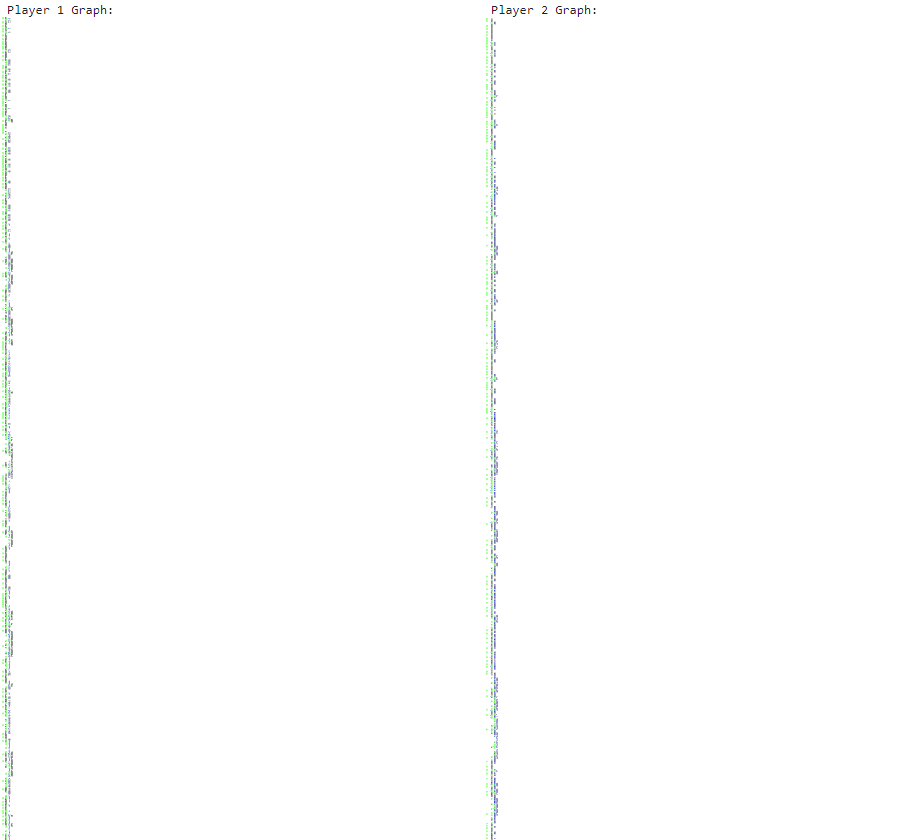